Load Required libraries

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import os
import sqlite3
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib
import pandas as pd
import requests
from arch.univariate.base import ARCHModelResult
from config import settings
from data import AlphaVantageAPI, SQLRepository
from arch import arch_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/baba/Library/Python/3.9/lib/python/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_directory" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


In [4]:
ticker = "MSFT"
interval = "1min"
data_type = "json"

url =  ("https://www.alphavantage.co/query?"
        "function=TIME_SERIES_INTRADAY&"
        f"symbol={ticker}&"
        f"interval={interval}&"
        f"datatype=json&"
        f"apikey={settings.alpha_api_key}")

    

print("url type:", type(url))
url

url type: <class 'str'>


'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=1min&datatype=json&apikey=1LDHCZV19GB3C9QF'

In [5]:
#Create an HTTP request for the URL you created above
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [6]:
# Get symbol in `"Meta Data"`
symbol_ = response.json()["Meta Data"]["2. Symbol"]
symbol_

'MSFT'

In [7]:
#Get status code of your response and assign it to the variable response_code
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

In [8]:
response_data = response.json()
#Extract Time Series[Daily] from the response_data
stock_data = response_data["Time Series (1min)"]
df_msft = pd.DataFrame.from_dict(stock_data, orient="index",dtype=float)

df_msft.index = pd.to_datetime(df_msft.index)
df_msft.index.name = "Date"

df_msft.columns=[c.split('. ')[1] for c in df_msft.columns]
print("df_msft type:", type(df_msft))

df_msft.head()

df_msft type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
Date,,,,,
2023-08-25 19:59:00,322.75,322.95,322.75,322.95,399.0
2023-08-25 19:58:00,322.94,322.94,322.87,322.94,18.0
2023-08-25 19:57:00,322.87,322.94,322.49,322.94,52.0
2023-08-25 19:56:00,322.89,322.89,322.80,322.80,157.0
2023-08-25 19:55:00,322.70,322.81,322.70,322.70,8.0


In [9]:
#size of the df_msft dataframe
df_msft.shape

(100, 5)

In [10]:
av = AlphaVantageAPI()

df_msft = av.get_daily(ticker="MSFT", interval="1min")
print("df_msft type:", type(df_msft))

df_msft.head()

df_msft type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2023-08-25 19:59:00,322.75,322.95,322.75,322.95,399.0
2023-08-25 19:58:00,322.94,322.94,322.87,322.94,18.0
2023-08-25 19:57:00,322.87,322.94,322.49,322.94,52.0
2023-08-25 19:56:00,322.89,322.89,322.80,322.80,157.0
2023-08-25 19:55:00,322.70,322.81,322.70,322.70,8.0


Connect to the database whose name is stored in the .env file for this project. Be sure to set the check_same_thread argument to False. Assign the connection to the variable connection.

In [11]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
connection

In [12]:
# Get location of database for `connection`
db_location = connection.cursor().execute("PRAGMA database_list;").fetchall()[0][-1]
db_location

'/Users/baba/Downloads/Volatility Forecasting Project/miscrosoft_corporation_financial_data'

In [13]:
#Insert df_msft into your database.
# Import class definition
from data import SQLRepository

# Create instance of class
repo = SQLRepository(connection=connection)

# Does `repo` have a "connection" attribute?
assert hasattr(repo, "connection")

# Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

In [14]:
MSFT = df_msft

In [15]:
response = repo.insert_table(table_name=ticker, records=MSFT, if_exists="replace")

# Does your method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

# Predicting Volatility

In [16]:
#Create a Series y_msft with the 100000 most recent returns for MSFT
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit=n_observations+1)


    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)


    # Create "return" column
    df["return"] = pd.to_numeric(
        df["close"], errors="coerce").pct_change()*100


    # Return returns
    return df["return"].dropna()

In [19]:
from model import GarchModel
y_msft = wrangle_data(ticker="MSFT", n_observations=100000)

print("y_msft type:", type(y_msft))
print("y_msft shape:", y_msft.shape)
y_msft.head()


# Get data for 8 Aug 2022
#data_2023_18_17 = (y_msft["2023-08-17"])
#data_2023_18_17

y_msft type: <class 'pandas.core.series.Series'>
y_msft shape: (99,)


date
2023-08-25 18:07:00   -0.015489
2023-08-25 18:08:00    0.003098
2023-08-25 18:09:00   -0.015491
2023-08-25 18:10:00    0.021691
2023-08-25 18:11:00    0.000000
Name: return, dtype: float64

In [20]:
#Calculate the per minute volatility for y_mtnoy, and assign the result to mtnoy_per_minute_volatility
msft_per_minute_volatility = y_msft.std()

print("msft_per_minute_volatility type:", type(msft_per_minute_volatility))
print("Microsoft Corporation Per Minute Volatility:", msft_per_minute_volatility)

msft_per_minute_volatility type: <class 'numpy.float64'>
Microsoft Corporation Per Minute Volatility: 0.04838619814246975


In [21]:
#Calculate the daily volatility for y_msft, and assign the result to msft_daily_volatility.
msft_daily_volatility = msft_per_minute_volatility * np.sqrt(1440)

print("msft_daily_volatility type:", type(msft_daily_volatility))
print("Microsoft Corporation Daily Volatility:", msft_daily_volatility)

msft_daily_volatility type: <class 'numpy.float64'>
Microsoft Corporation Daily Volatility: 1.8361271213569539


In [22]:
msft_annual_volatility = msft_daily_volatility * np.sqrt(252)

print("msft_annual_volatility type:", type(msft_annual_volatility))
print("Microsoft Corporation Annual Volatility:", msft_annual_volatility)

msft_annual_volatility type: <class 'numpy.float64'>
Microsoft Corporation Annual Volatility: 29.147614431668483


Create a time series line plot for y_msft. Be sure to label the x-axis "Time", the y-axis "Returns", and use the title "Time Series of Microsfot Corporation Returns"

Text(0.5, 1.0, 'Time Series of Microsfot Corporation Returns')

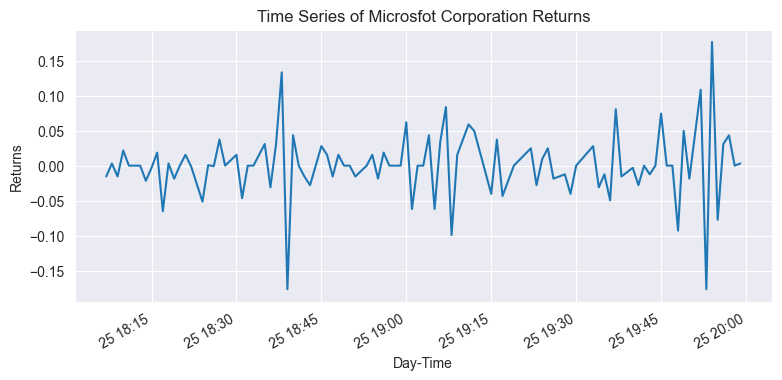

In [23]:
# Create `fig` and `ax`
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 4))

# Plot `y_mtnoy` on `ax`
y_msft.plot(ax=ax, label="per_minute return")
# Add axis labels

plt.xlabel("Day-Time")
plt.ylabel("Returns")

# Add title
plt.title("Time Series of Microsfot Corporation Returns")

Create an ACF plot of the squared returns for MSFT. Be sure to label the x-axis "Lag [minutes]", the y-axis "Correlation Coefficient", and use the title "ACF of Microsoft Corporation Squared Returns".

Text(0.5, 1.0, 'ACF of MSFT Squared Returns')

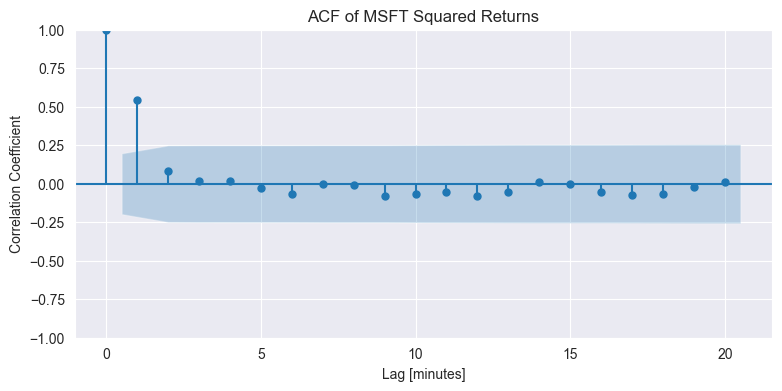

In [24]:
# Create `fig` and `ax`

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 4))
# Create ACF of squared returns
plot_acf(y_msft**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [minutes]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("ACF of MSFT Squared Returns")

Create an PACF plot of the squared returns for MSFT. Be sure to label the x-axis "Lag [minutes]", the y-axis "Correlation Coefficient", and use the title "PACF of Microsoft Corporation Squared Returns".

Text(0.5, 1.0, 'PACF of MSFT Squared Returns')

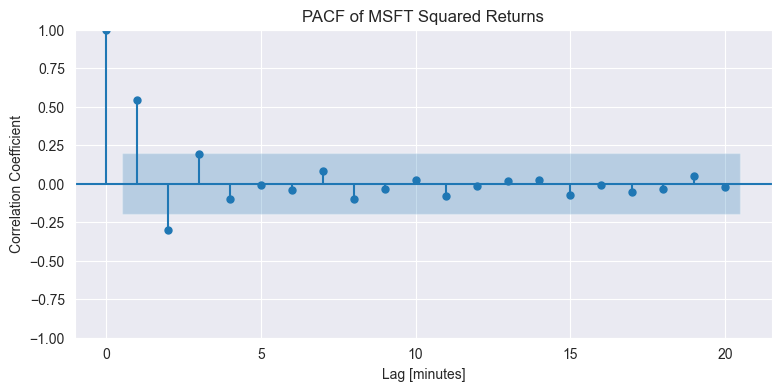

In [25]:
#Create fig and ax
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 4))
# Create ACF of squared returns
plot_pacf(y_msft**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [minutes]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("PACF of MSFT Squared Returns")


In [26]:
#Create a training set y_msft_train that contains the first 80% of the observations in y_msft.
cutoff_test = int(len(y_msft) * 0.8)
y_msft_train = y_msft.iloc[:cutoff_test].sort_index(ascending=True)

print("y_msft_train type:", type(y_msft_train))
print("y_msft_train shape:", y_msft_train.shape)

y_msft_train type: <class 'pandas.core.series.Series'>
y_msft_train shape: (79,)


In [27]:
y_msft_train.dropna(inplace=True)

Build and fit a GARCH model using the data in y_msft. Try different values for p and q, using the summary to assess its performance.

In [28]:
# Build and train model
model = arch_model(
y_msft_train,
p=1,
q=1,
rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                154.940
Distribution:                  Normal   AIC:                          -301.879
Method:            Maximum Likelihood   BIC:                          -292.401
                                        No. Observations:                   79
Date:                Mon, Aug 28 2023   Df Residuals:                       78
Time:                        15:24:10   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.4395e-03  2.805e-03     -0.870      0.384 [-7.937e-03,3.058e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.0360e-04  1.900e-04      3.177  1.488e-03 [2.312e-04,9.760e-04]
alpha[1]       0.7664      0.410      1.868  6.182e-02  [-3.790e-02,  1.571]
beta[1]        0.0138  9.676e-02      0.142      0.887     [ -0.176,  0.203]
============================================================================

Covariance estimator: robust
"""

Plot the standardized residuals for your model. Be sure to label the x-axis "Time", the y-axis "Value", and use the title "MSFT GARCH Model Standardized Residuals".

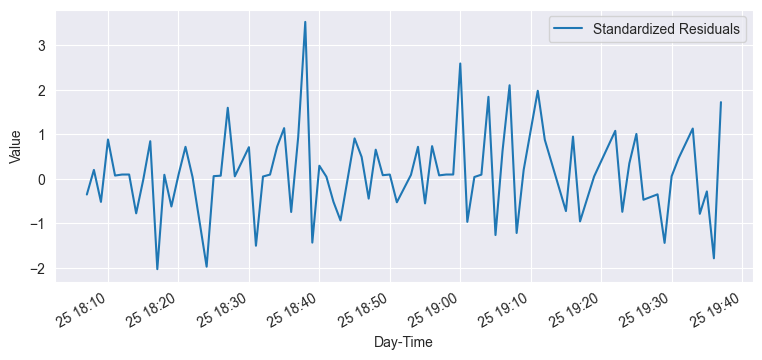

In [29]:
# Create `fig` and `ax`
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9,4))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Day-Time")
plt.ylabel("Value")

# Add legend
plt.legend();

Create an ACF plot of the squared, standardized residuals of the model. Be sure to label the x-axis "Lag [Time: Minutes]", the y-axis "Correlation Coefficient", and use the title "ACF of MSFT GARCH Model Standardized Residuals".

Text(0.5, 1.0, 'ACF of MSFT GARCH Model Standardized Residuals')

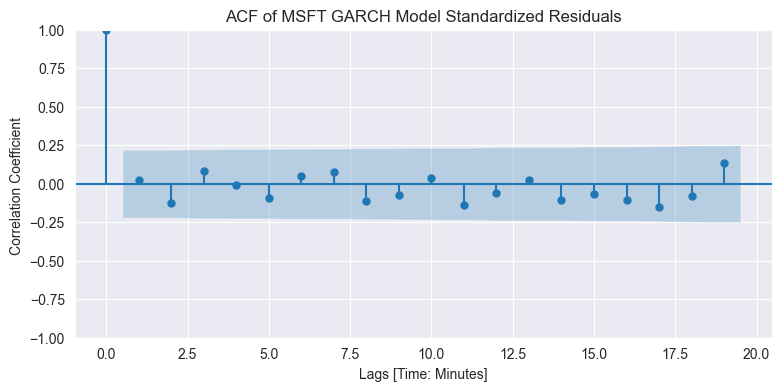

In [30]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 4))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lags [Time: Minutes]")
plt.ylabel("Correlation Coefficient ")
# Add title
plt.title("ACF of MSFT GARCH Model Standardized Residuals")

# Model Deployment

Change the fit method of the GarchModel class so that, when the model is done training, two more attributes are added to the object: self.aic with the AIC for the model, and self.bic with the BIC for the model.

In [31]:
# Import `build_model` function
from main import build_model

# Build model using new `MTNOY` data
model = build_model(ticker="MSFT", use_new_data=False)

# Wrangle `MTNOY` returns
model.wrangle_data(n_observations=100000)



# Fit GARCH(1,1) model to data
model.fit(p=1, q=1)

# Does model have AIC and BIC attributes?
assert hasattr(model, "aic")
assert hasattr(model, "bic")

In [32]:
# Import `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="MSFT", use_new_data=False, n_observations=100000, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

{'ticker': 'MSFT',
 'use_new_data': False,
 'n_observations': 100000,
 'p': 1,
 'q': 1,
 'success': True,
 'message': 'Trained and saved /Users/baba/Volatility Forecasting Project/2023-08-28T15:24:27.730655_MSFT.pkl. Metrics: AIC -349.54922543756965, BIC -339.16874603703127.'}

Create a post request to hit the "/fit" path running at "http://localhost:8008". You should train a GARCH(1,1) model on 100000 observations of the MSFT data you already downloaded. Pass in your parameters as a dictionary using the json argument. The grader will evaluate the JSON of your response.

In [34]:
# URL of `/fit` path
url = "http://localhost:8008/fit"

# Data to send to path
json = {
    "ticker": "MSFT",
    "use_new_data":False,
    "n_observations": 100000,
    "p": 1,
    "q":1
}
# Response of post request
response = requests.post(url=url, json=json)
# Inspect response
print("response code:", response.status_code)
response.json()

response code: 200


{'ticker': 'MSFT',
 'use_new_data': False,
 'n_observations': 100000,
 'p': 1,
 'q': 1,
 'success': True,
 'message': 'Trained and saved /Users/baba/Volatility Forecasting Project/2023-08-28T15:26:02.177304_MSFT.pkl. Metrics: AIC -349.54919254787137, BIC -339.168713147333.'}

In [35]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to send to path
json = {"ticker": "MSFT", "n_minutes": 66}
# Response of post request
response = requests.post(url, json=json)
print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


In [36]:
response.json()

{'ticker': 'MSFT',
 'n_minutes': 66,
 'success': True,
 'forecast': {'2023-08-25T20:00:00': 0.03156699395550719,
  '2023-08-25T20:01:00': 0.039066489914839964,
  '2023-08-25T20:02:00': 0.04256452268449342,
  '2023-08-25T20:03:00': 0.044335829826089836,
  '2023-08-25T20:04:00': 0.04526192292757472,
  '2023-08-25T20:05:00': 0.04575336662015133,
  '2023-08-25T20:06:00': 0.04601610664458321,
  '2023-08-25T20:07:00': 0.046157118635689394,
  '2023-08-25T20:08:00': 0.0462329540170436,
  '2023-08-25T20:09:00': 0.04627378221195112,
  '2023-08-25T20:10:00': 0.0462957760843435,
  '2023-08-25T20:11:00': 0.046307627747412525,
  '2023-08-25T20:12:00': 0.04631401523575676,
  '2023-08-25T20:13:00': 0.04631745810384956,
  '2023-08-25T20:14:00': 0.04631931390695259,
  '2023-08-25T20:15:00': 0.04632031426359692,
  '2023-08-25T20:16:00': 0.04632085350595336,
  '2023-08-25T20:17:00': 0.04632114418683023,
  '2023-08-25T20:18:00': 0.046321300880235505,
  '2023-08-25T20:19:00': 0.0463213853470163,
  '2023-08-

Go to the command line, navigate to the directory for this project, and start your app server by entering the following command.

uvicorn main:app --reload --workers 1 --host localhost --port 8008
Remember how the AlphaVantage API had a "/query" path that we accessed using a get HTTP request? We're going to build similar paths for our application. Let's start with an MVP example so we can learn how paths work in FastAPI.